In [11]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
#import seaborn as sns
import math
import scipy
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
from random import shuffle
import gw_ecc_calc as gwcalc
import unit_convert as uc
import psr_catalog as pc
import dynamics as dyn
#import readdata_harris as rd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


twopi=2.*np.pi
yearsc=3.1557*10**7
figsave='/projects/b1095/syr904/projects/PULSAR2/newruns'
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
PC=3.086*10**18  ##cm

savepath='/projects/b1095/syr904/projects/PULSAR_Catalog/newruns'

2.1.2


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/software/anaconda3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/software/anaconda3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/software/anaconda3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    iolo

In [2]:
def addColorbar(
    ax,cmap,
    vmin,vmax,
    label,logflag = 0,
    fontsize=16,cmap_number=0,
    tick_tuple=None):
    if logflag:
        from matplotlib.colors import LogNorm as norm
        ticks = np.linspace(np.log10(vmin),np.log10(vmax),5,endpoint=True)
        tick_labels= [r"$10^{%.1f}$"%tick for tick in ticks]
        ticks = 10**ticks
    else:
        from matplotlib.colors import Normalize as norm
        ticks = np.linspace(vmin,vmax,5,endpoint=True)
        tick_labels= ticks
    
    if tick_tuple is not None:
        ticks,tick_labels = tick_tuple

    fig = ax.get_figure()
    
    ## x,y of bottom left corner, width,height in percentage of figure size
    ## matches the default aspect ratio of matplotlib
    cur_size = fig.get_size_inches()*fig.dpi        

    cur_height = cur_size[1]
    cur_width = cur_size[0]
    offset = 0.00 + cmap_number*(25/cur_width+50/cur_width)

    ax1 = fig.add_axes([0.91 + offset, 0.135, 25./cur_width, 0.75])

    cb1 = matplotlib.colorbar.ColorbarBase(
        ax1, cmap=cmap,
        #extend='both',
        extendfrac=0.05,
        norm=norm(vmin=vmin,vmax=vmax),
        orientation='vertical')


    #cb1.set_label(label,fontsize=fontsize)

    cb1.set_ticks(ticks)
    cb1.set_ticklabels(tick_labels)
    cb1.ax.tick_params(labelsize=fontsize-2)
    return cb1,ax1

In [3]:
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    color47 = ['cyan', 'cyan', 'k', 'k', 'k', 'k', 'cyan', 'k', 'cyan', 'cyan', 'cyan', 'r', 'r', 'cyan', 'cyan', 'k', 'r']
    ax.scatter(x1, y1, s = 10,  label = 'Model MSPs', marker = '^', color = 'green', alpha=0.5)
    ax.scatter(x2, y2, s=10, label = 'Model Tidal Capture NS-MS', alpha = 0.5, color = 'orange')
    ax.scatter(mc47, pb47, marker = '*', s = 150, color = 'k', facecolor = color47, alpha = 1., 
               label = 'Observed MSPs')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    for xx in range(len(mc47)):
        ax_histx.axvline(x = mc47[xx], color = color47[xx], lw = 1)
    for xx in range(len(mc47)):
        ax_histy.axhline(y = pb47[xx], color = color47[xx], lw = 1)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 30), 
                  log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 30), orientation='horizontal',
                 log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x2)), np.log10(np.max(x2)), 5), 
                  log=True, color = 'orange', histtype = 'step', lw = 3)
    ax_histy.hist(y2, bins=np.logspace(np.log10(np.min(y2)), np.log10(np.max(y2)), 5), orientation='horizontal',
                 log=True, color = 'orange', histtype = 'step', lw = 3)
    
    ax.set_xlim(xmin = 0.004, xmax = 1.5)
    ax.set_ylim(ymin = 0.01, ymax = 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_{comp}\, (\rm{M_{\odot}})$')
    ax.set_ylabel(r'$P_{orb}\,$(days)')
    ax.legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

In [3]:
##Read the data of the new models
data=np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/table_allnums.txt')
Nini=data[:,1]; rvini=data[:,2]; zini=data[:,3]; rgini=data[:,4]
rc=data[:,5]; rhl=data[:,6]; mtot=data[:,7]; Nbh=data[:,8]; Nns=data[:,9]; Npsr=data[:,10]; Nmsp=data[:,11]
Ngwcap=data[:,12]; Nincluster=data[:,13]; Nesc=data[:,14]; Nescmerge=data[:,15]; DNS=data[:,16]; NSBH=data[:,17]

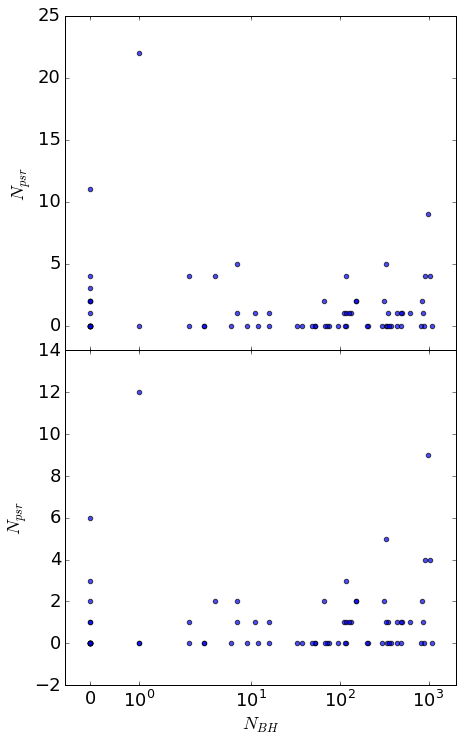

In [19]:
##Nbh vs. Npsr
plt.rcParams['figure.figsize'] = [7, 12]
fig, (ax1, ax2)=plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(Nbh, Npsr, s=20, alpha=0.7)
ax1.set_xscale('symlog')
#ax1.set_yscale('symlog')
ax1.set_ylim(-2, 25)
ax1.set_xlim(-0.5, 2000)
ax1.set_xlabel(r'$N_{BH}$')
ax1.set_ylabel(r'$N_{psr}$')

ax2.scatter(Nbh, Nmsp, s=20, alpha=0.7)
ax2.set_xscale('symlog')
#ax2.set_yscale('symlog')
#ax2.set_ylim(-2, 25)
ax2.set_xlim(-0.5, 2000)
ax2.set_xlabel(r'$N_{BH}$')
ax2.set_ylabel(r'$N_{psr}$')


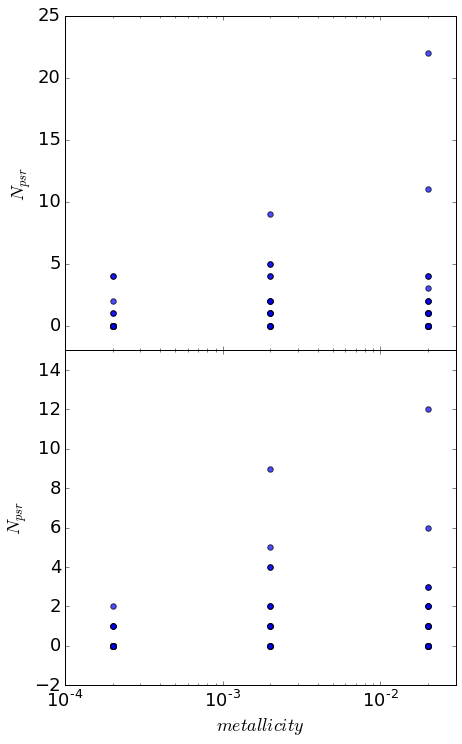

In [27]:
##Z vs. Npsr
plt.rcParams['figure.figsize'] = [7, 12]
fig, (ax1, ax2)=plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(zini, Npsr, s=30, alpha=0.7)
ax1.set_xscale('log')
#ax1.set_yscale('symlog')
ax1.set_ylim(-2, 25)
ax1.set_xlim(0.0001, 0.03)
ax1.set_xlabel(r'$metallicity$')
ax1.set_ylabel(r'$N_{psr}$')

ax2.scatter(zini, Nmsp, s=30, alpha=0.7)
ax2.set_xscale('log')
#ax2.set_yscale('symlog')
ax2.set_ylim(-2, 15)
ax2.set_xlim(0.0001, 0.03)
ax2.set_xlabel(r'$metallicity$')
ax2.set_ylabel(r'$N_{psr}$')


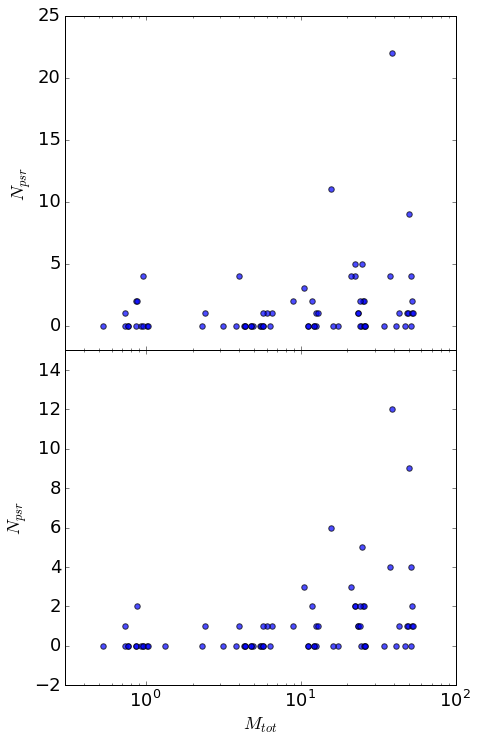

In [32]:
##Mtot vs. Npsr
plt.rcParams['figure.figsize'] = [7, 12]
fig, (ax1, ax2)=plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(mtot, Npsr, s=30, alpha=0.7)
ax1.set_xscale('log')
#ax1.set_yscale('symlog')
ax1.set_ylim(-2, 25)
ax1.set_xlim(0.3, 100)
ax1.set_xlabel(r'$m_{tot}y$')
ax1.set_ylabel(r'$N_{psr}$')

ax2.scatter(mtot, Nmsp, s=30, alpha=0.7)
ax2.set_xscale('log')
#ax2.set_yscale('symlog')
ax2.set_ylim(-2, 15)
ax2.set_xlim(0.3, 100)
ax2.set_xlabel(r'$M_{tot}$')
ax2.set_ylabel(r'$N_{psr}$')


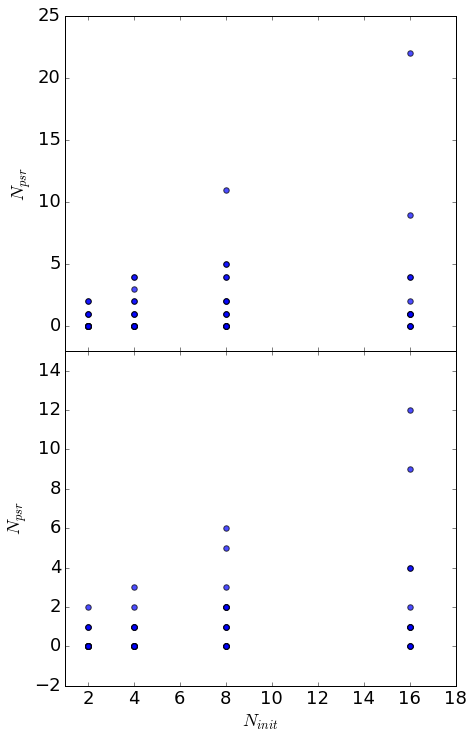

In [5]:
##N vs. Npsr
plt.rcParams['figure.figsize'] = [7, 12]
fig, (ax1, ax2)=plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(Nini, Npsr, s=30, alpha=0.7)
#ax1.set_xscale('log')
#ax1.set_yscale('symlog')
ax1.set_ylim(-2, 25)
ax1.set_xlim(1, 18)
ax1.set_xlabel(r'$N _{init}$')
ax1.set_ylabel(r'$N_{psr}$')

ax2.scatter(Nini, Nmsp, s=30, alpha=0.7)
#ax2.set_xscale('log')
#ax2.set_yscale('symlog')
ax2.set_ylim(-2, 15)
ax2.set_xlim(1, 18)
ax2.set_xlabel(r'$N_{init}$')
ax2.set_ylabel(r'$N_{psr}$')

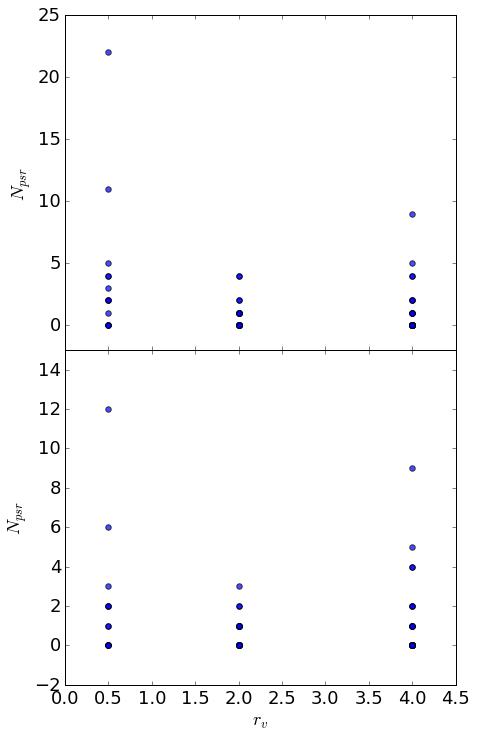

In [5]:
##N vs. Npsr
plt.rcParams['figure.figsize'] = [7, 12]
fig, (ax1, ax2)=plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(rvini, Npsr, s=30, alpha=0.7)
#ax1.set_xscale('log')
#ax1.set_yscale('symlog')
ax1.set_ylim(-2, 25)
#ax1.set_xlim(1, 18)
ax1.set_xlabel(r'r _v$')
ax1.set_ylabel(r'$N_{psr}$')

ax2.scatter(rvini, Nmsp, s=30, alpha=0.7)
#ax2.set_xscale('log')
#ax2.set_yscale('symlog')
ax2.set_ylim(-2, 15)
#ax2.set_xlim(1, 18)
ax2.set_xlabel(r'$r_v$')
ax2.set_ylabel(r'$N_{psr}$')

Nbw= 4 Nnormal= 0 Nexotica= 2 Nsingle= 3


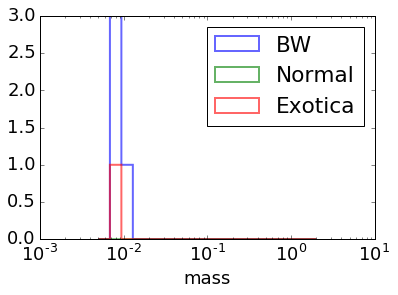

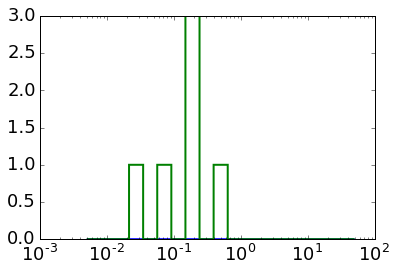

In [3]:
##Type of MSPs for old models
datamsp_old=np.genfromtxt('/projects/b1095/syr904/projects/NGC6624/msps_438.dat')
datapsr_old=np.genfromtxt('/projects/b1095/syr904/projects/NGC6624/normalpsrs_438.dat')
m0_msp=datamsp_old[:,6]; m1_msp=datamsp_old[:,7]; sma_msp=datamsp_old[:,10]; ecc_msp=datamsp_old[:,11]
r_msp=datamsp_old[:,17]
m0_psr=datapsr_old[:,6]; m1_psr=datapsr_old[:,7]; sma_psr=datapsr_old[:,10]; ecc_psr=datapsr_old[:,11]
r_psr=datapsr_old[:,17]

m_bw=[]; m_normal=[]; m_exotica=[]; m_single=[]
r_bw=[]; r_normal=[]; r_exotica=[]; r_single=[]
a_bw=[]; a_normal=[]; a_exotica=[]
r_light=[]; r_heavy=[]

for i in range(len(m0_msp)):
    if m1_msp[i]>=0.1 and ecc_msp[i]<=0.01:
        m_normal.append(m1_msp[i])
        r_normal.append(r_msp[i])
        r_heavy.append(r_msp[i])
    if m1_msp[i]<0.1 and m1_msp[i]>0 and ecc_msp[i]<=0.01:
        m_bw.append(m1_msp[i])
        r_bw.append(r_msp[i])
        r_light.append(r_msp[i])
    if ecc_msp[i]>0.01:
        m_exotica.append(m1_msp[i])
        r_exotica.append(r_msp[i])
        if m1_msp[i]>=0.1:
            r_heavy.append(r_msp[i])
        if m1_msp[i]<0.1 and m1_msp[i]>0:
            r_light.append(r_msp[i])
    if m1_msp[i]==-100:
        m_single.append(m1_msp[i])
        r_single.append(r_msp[i])
        
for j in range(len(m0_psr)):
    if m1_psr[j]>=0.1 and ecc_psr[j]<=0.01:
        m_normal.append(m1_psr[j])
        r_normal.append(r_psr[j])
        r_heavy.append(r_psr[j])
    if m1_psr[j]<0.1 and m1_psr[j]>0 and ecc_psr[j]<=0.01:
        m_bw.append(m1_psr[j])
        r_bw.append(r_psr[j])
        r_light.append(r_psr[j])
    if ecc_psr[j]>0.01:
        m_exotica.append(m1_psr[j])
        r_exotica.append(r_psr[j])
        if m1_psr[j]>=0.1:
            r_heavy.append(r_psr[j])
        if m1_psr[j]<0.1 and m1_psr[j]>0:
            r_light.append(r_psr[j])
    if m1_psr[j]==-100:
        m_single.append(m1_psr[j])
        r_single.append(r_psr[j])
    

print 'Nbw=',len(m_bw), 'Nnormal=', len(m_normal), 'Nexotica=', len(m_exotica), 'Nsingle=', len(m_single)


plt.figure()
plt.hist(m_bw, bins=np.logspace(np.log10(0.005),np.log10(2), 20),  histtype='step', lw=2, label='BW', alpha=0.6)
plt.hist(m_normal, bins=np.logspace(np.log10(0.005),np.log10(2), 20), histtype='step', lw=2, label='Normal', alpha=0.6)
plt.hist(m_exotica, bins=np.logspace(np.log10(0.005),np.log10(2), 20), histtype='step', lw=2, label='Exotica', alpha=0.6)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('mass')
plt.legend(loc='upper right')

plt.figure()
plt.hist(r_heavy, bins=np.logspace(np.log10(0.005),np.log10(50), 20), histtype='step', lw=2)
plt.hist(r_light, bins=np.logspace(np.log10(0.005),np.log10(50), 20), histtype='step', lw=2)
plt.xscale('log')

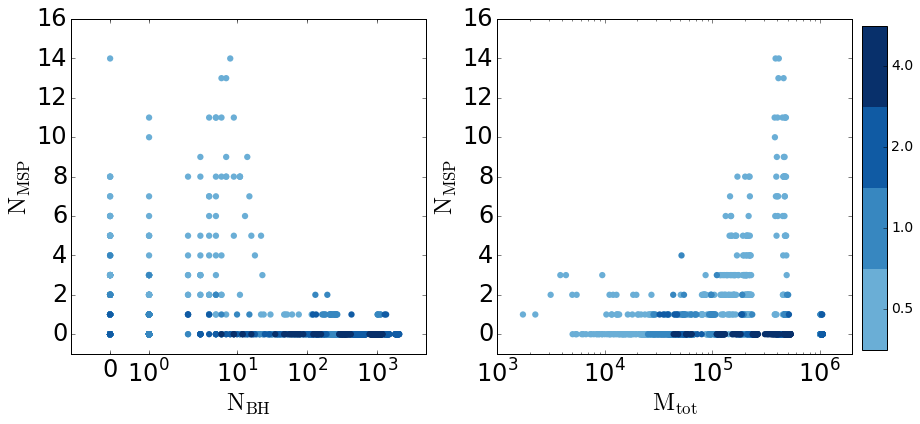

In [25]:
##Plot Npsr vs Nbh and Npsr vs Ninit
data=np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_number_9to14Gyr_main_32e5.dat')

Models=data[:,0]; Nbh=data[:,3]; Npsr=data[:,8]; Nmsp=data[:,11]
Ninit=data[:,14]; rv=data[:,15]; z=data[:,16]; rg=data[:,17]
times=data[:,1]; Mtot=data[:,2]

Npsr_all=[]; Nmsp_all=[]; Ninit_all=[]; Nbh_all=[]; Mtot_all=[]
RV=[0.5, 1.0, 2.0, 4.0]
for i in range(4):
    Npsr_all.append([]); Nmsp_all.append([]); Ninit_all.append([]); Nbh_all.append([]); Mtot_all.append([])
    for j in range(len(Models)):
        if rv[j]==RV[i] and 10.<=times[j]<=13.:
            Npsr_all[i].append(Npsr[j]); Nmsp_all[i].append(Nmsp[j])
            Ninit_all[i].append(Ninit[j]); Nbh_all[i].append(Nbh[j])
            Mtot_all[i].append(Mtot[j])

matplotlib.rcParams.update({'font.size': 24})
plt.rcParams['figure.figsize'] = [14, 6]   

c = cm.Blues(np.linspace(0.5, 1, 4))
cmap=matplotlib.colors.ListedColormap([c[0], c[1], c[2], c[3]])


fig, (ax1, ax2)=plt.subplots(ncols=2)
for k in range(4):
    ax1.scatter(Nbh_all[k], Nmsp_all[k], s=40, color=c[k], cmap=cmap, edgecolors='none')
    ax2.scatter(Mtot_all[k], Nmsp_all[k], s=40, color=c[k], cmap=cmap, edgecolors='none')

addColorbar(ax2, cmap, 0, 8, label=None, tick_tuple=([1.,3.,5.,7.],[0.5, 1.0, 2.0, 4.0]))

ax1.set_xscale('symlog')
ax2.set_xscale('log')
ax1.set_xlim(-1, 5000)
ax2.set_xlim(1e3, 2*1e6)
ax1.set_ylim(-1.0, 16)
ax2.set_ylim(-1.0, 16)

ax1.set_xlabel(r'$\rm{N_{BH}}$')
ax1.set_ylabel(r'$\rm{N_{MSP}}$')
ax2.set_xlabel(r'$\rm{M_{tot}}$')
ax2.set_ylabel(r'$\rm{N_{MSP}}$')

#plt.tight_layout()

plt.savefig('/projects/b1095/syr904/projects/PULSAR2/NpsrvsNbh_v3.pdf', dpi=fig.dpi, bbox_inches='tight')

5.2 2.7
5.68421052632 2.84210526316
9.72727272727 0.454545454545
9.04761904762 2.85714285714
20.2777777778 8.88888888889
0.175438596491 0.175438596491
7.27272727273 2.63636363636
0.0 0.0
1.47619047619 1.38095238095
5.17647058824 2.41176470588
6.07692307692 0.0769230769231
0.0952380952381 0.047619047619
4.46428571429 1.57142857143
14.0869565217 6.26086956522
0.2 0.2
1.12030075188 0.12030075188
4.66666666667 3.61111111111
1.0 0.0
1.17647058824 0.176470588235
3.0 1.0
14.0 0.142857142857
0.0 0.0
3.52941176471 0.294117647059
4.33333333333 2.14285714286
15.3333333333 6.33333333333
0.40625 0.40625
0.0 0.0
1.0 0.0
1.55555555556 0.888888888889
1.0 0.0
3.0 0.0
0.947368421053 0.410526315789
1.9 0.8
2.36363636364 0.0909090909091
0.0 0.0
2.65 0.5
1.0 0.0
4.0 0.0
0.0952380952381 0.0952380952381
0.0 0.0
0.0 0.0
3.85 0.85
0.1 0.0
2.66666666667 0.444444444444
1.625 0.375
3.1 0.9
0.0 0.0
2.16666666667 0.416666666667
0.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
4.78947368421 0.0
1.0 1.0
1.0 0.0
2.33333333333 

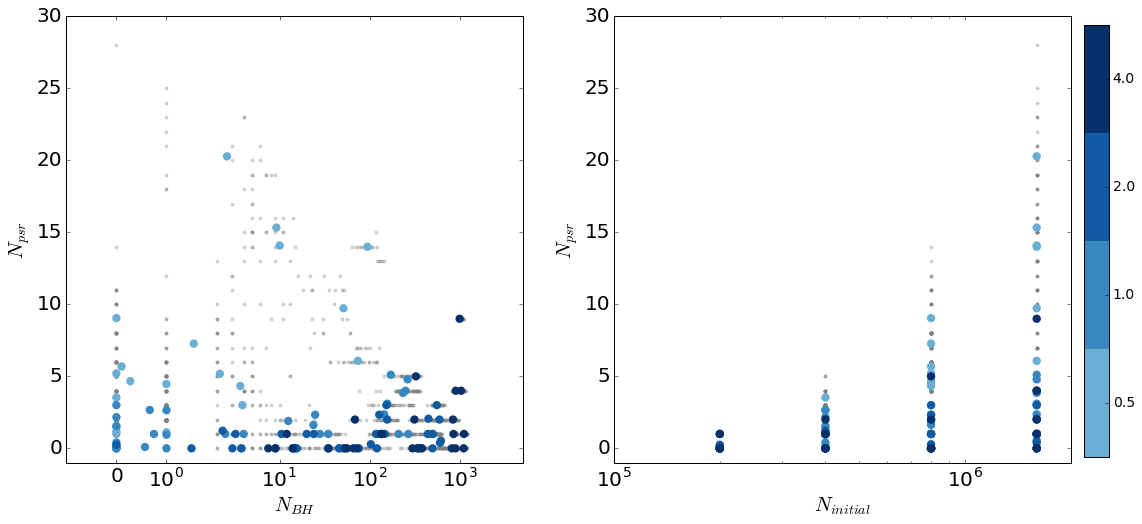

In [106]:
##Plot Npsr vs Nbh and Npsr vs Ninit with average numbers
sourcedir=np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/path_nondissolved_newruns.dat', dtype='str')
data=np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_number_9to12Gyr_maingrid.dat')

Models=data[:,0]; Nbh=data[:,3]; Npsr=data[:,8]; Nmsp=data[:,11]; time=data[:,1]
Ninit=data[:,14]; rv=data[:,15]; z=data[:,16]; rg=data[:,17]

all_modelno=Counter(Models).keys()
Npsr_all=[]; Nmsp_all=[]; Ninit_all=[]; Nbh_all=[]
RV=[0.5, 1.0, 2.0, 4.0]
for i in range(4):
    Npsr_all.append([]); Nmsp_all.append([]); Ninit_all.append([]); Nbh_all.append([])
    for j in range(len(all_modelno)):
        Npsr_sum=0; Nmsp_sum=0; Nbh_sum=0
        count=0
        for k in range(len(Models)):
            if Models[k]==all_modelno[j]:
                if 10.0<=time[k]<=14.0:
                    Npsr_sum=Npsr_sum+Npsr[k]; Nmsp_sum=Nmsp_sum+Nmsp[k]; Nbh_sum=Nbh_sum+Nbh[k]
                    count+=1
                    rv_model=rv[k]; Ninit_model=Ninit[k]
        Npsr_ave=float(Npsr_sum)/float(count); Nmsp_ave=float(Nmsp_sum)/float(count); Nbh_ave=float(Nbh_sum)/float(count)
        
        if rv_model==RV[i]:
            Npsr_all[i].append(Npsr_ave); Nmsp_all[i].append(Nmsp_ave)
            Ninit_all[i].append(Ninit_model); Nbh_all[i].append(Nbh_ave)


matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [18, 8]   
c = cm.Blues(np.linspace(0.5, 1, 4))
cmap=matplotlib.colors.ListedColormap([c[0], c[1], c[2], c[3]])
fig, (ax1, ax2)=plt.subplots(ncols=2)
for k in range(4):
    ax1.scatter(Nbh_all[k], Npsr_all[k], edgecolor='None', s=70, color=c[k], zorder=2)
    ax2.scatter(Ninit_all[k], Npsr_all[k], edgecolor='None', s=70, color=c[k], zorder=2)

ax1.scatter(Nbh, Npsr, color='grey', s=8, alpha=0.3, zorder=1)
ax2.scatter(Ninit, Npsr, color='grey', s=8, alpha=0.3, zorder=1)

addColorbar(ax2, cmap, 0, 8, label=None, tick_tuple=([1.,3.,5.,7.],[0.5, 1.0, 2.0, 4.0]))


ax1.set_xscale('symlog')
ax2.set_xscale('log')
ax1.set_xlim(-1, 5000)
ax2.set_xlim(1e5, 2*1e6)
ax1.set_ylim(-1.0, 30)
ax2.set_ylim(-1.0, 30)

ax1.set_xlabel(r'$N_{BH}$')
ax1.set_ylabel(r'$N_{psr}$')
ax2.set_xlabel(r'$N_{initial}$')
ax2.set_ylabel(r'$N_{psr}$')

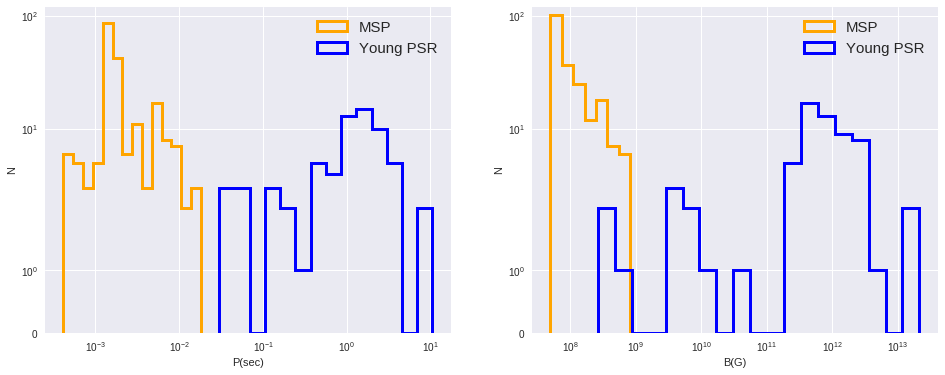

In [34]:
##Distribution of periods and magnetic fields
datamsp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/msp_maingrid_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/normalpsr_maingrid_last.dat')

Bmsp=datamsp[:,4]; Pmsp=datamsp[:,5]
Bpsr=datapsr[:,4]; Ppsr=datapsr[:,5]

matplotlib.rcParams.update({'font.size': 24})
plt.rcParams['figure.figsize'] = [16, 6] 
fig, axs=plt.subplots(1, 2)
axs[0].hist(Pmsp, bins=np.logspace(np.log10(np.min(Pmsp)),np.log10(np.max(Pmsp)), 15), 
         color='orange', histtype='step', lw=3., label='MSP')
axs[0].hist(Ppsr, bins=np.logspace(np.log10(np.min(Ppsr)),np.log10(np.max(Ppsr)), 15),
         color='blue', histtype='step', lw=3., label='Young PSR')

axs[0].set_xscale('log')
axs[0].set_yscale('symlog')
axs[0].set_ylim(0, 120)
axs[0].set_xlabel('P(sec)')
axs[0].set_ylabel('N')
axs[0].legend(loc='best',  fontsize=15)


axs[1].hist(Bmsp, bins=np.logspace(np.log10(np.min(Bmsp)),np.log10(np.max(Bmsp)), 8), 
         color='orange', histtype='step', lw=3., label='MSP')
axs[1].hist(Bpsr, bins=np.logspace(np.log10(np.min(Bpsr)),np.log10(np.max(Bpsr)), 20),
         color='blue', histtype='step', lw=3., label='Young PSR')

axs[1].set_xscale('log')
axs[1].set_yscale('symlog')
axs[1].set_ylim(0, 120)

axs[1].set_xlabel('B(G)')
axs[1].set_ylabel('N')

axs[1].legend(loc='best', fontsize=15)


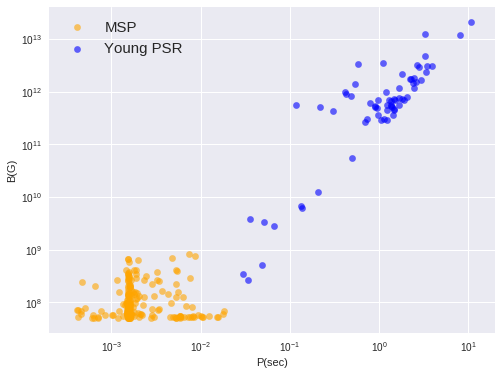

In [36]:
##B--P plot
datamsp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/msp_maingrid_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/normalpsr_maingrid_last.dat')

Bmsp=datamsp[:,4]; Pmsp=datamsp[:,5]
Bpsr=datapsr[:,4]; Ppsr=datapsr[:,5]

matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [8, 6] 

plt.figure()
plt.scatter(Pmsp, Bmsp, color='orange', s=40, alpha=0.6, label='MSP')
plt.scatter(Ppsr, Bpsr, color='blue', s=40, alpha=0.6, label='Young PSR')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0002, 20)

plt.xlabel('P(sec)')
plt.ylabel('B(G)')

plt.legend(loc='best', fontsize=15)


207 66
Nbw= 139 Nnormal= 12 Nexotica= 20 Nsingle= 102


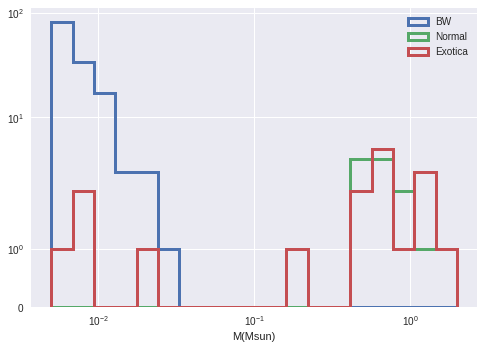

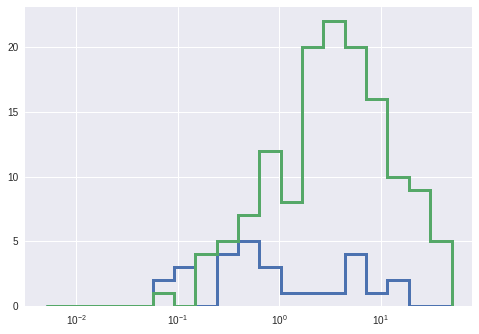

In [4]:
##Companion types for Pulsars
##Type of PSRs

datamsp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/msp_maingrid_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/normalpsr_maingrid_last.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
r_msp=datamsp[:,3]
m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
r_psr=datapsr[:,3]

m_bw=[]; m_normal=[]; m_exotica=[]; m_single=[]
r_bw=[]; r_normal=[]; r_exotica=[]; r_single=[]
a_bw=[]; a_normal=[]; a_exotica=[]
r_light=[]; r_heavy=[]

print(len(m0_msp), len(m0_psr))

for i in range(len(m0_msp)):
    if m1_msp[i]>=0.1 and ecc_msp[i]<=0.01:
        m_normal.append(m1_msp[i])
        r_normal.append(r_msp[i])
        r_heavy.append(r_msp[i])
    if m1_msp[i]<0.1 and m1_msp[i]>0 and ecc_msp[i]<=0.01:
        m_bw.append(m1_msp[i])
        r_bw.append(r_msp[i])
        r_light.append(r_msp[i])
    if ecc_msp[i]>0.01:
        m_exotica.append(m1_msp[i])
        r_exotica.append(r_msp[i])
        if m1_msp[i]>=0.1:
            r_heavy.append(r_msp[i])
        if m1_msp[i]<0.1 and m1_msp[i]>0:
            r_light.append(r_msp[i])
    if m1_msp[i]==-100:
        m_single.append(m1_msp[i])
        r_single.append(r_msp[i])
        
for j in range(len(m0_psr)):
    if m1_psr[j]>=0.1 and ecc_psr[j]<=0.01:
        m_normal.append(m1_psr[j])
        r_normal.append(r_psr[j])
        r_heavy.append(r_psr[j])
    if m1_psr[j]<0.1 and m1_psr[j]>0 and ecc_psr[j]<=0.01:
        m_bw.append(m1_psr[j])
        r_bw.append(r_psr[j])
        r_light.append(r_psr[j])
    if ecc_psr[j]>0.01:
        m_exotica.append(m1_psr[j])
        r_exotica.append(r_psr[j])
        if m1_psr[j]>=0.1:
            r_heavy.append(r_psr[j])
        if m1_psr[j]<0.1 and m1_psr[j]>0:
            r_light.append(r_psr[j])
    if m1_psr[j]==-100:
        m_single.append(m1_psr[j])
        r_single.append(r_psr[j])
    

print('Nbw=',len(m_bw), 'Nnormal=', len(m_normal), 'Nexotica=', len(m_exotica), 'Nsingle=', len(m_single))


plt.figure()
plt.hist(m_bw, bins=np.logspace(np.log10(0.005),np.log10(2), 20),  histtype='step', lw=3, label='BW', alpha=1.)
plt.hist(m_normal, bins=np.logspace(np.log10(0.005),np.log10(2), 20), histtype='step', lw=3, label='Normal', alpha=1.)
plt.hist(m_exotica, bins=np.logspace(np.log10(0.005),np.log10(2), 20), histtype='step', lw=3, label='Exotica', alpha=1.)
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('M(Msun)')
plt.legend(loc='upper right')

plt.figure()
plt.hist(r_heavy, bins=np.logspace(np.log10(0.005),np.log10(50), 20), histtype='step', lw=3)
plt.hist(r_light, bins=np.logspace(np.log10(0.005),np.log10(50), 20), histtype='step', lw=3)
plt.xscale('log')



280
280 280
['0.00031', '0.07056', '<0.0004', '<0.00004', '<0.00016', '0.0', '0.00008', '0.0', '0.00039', '0.00040', '0.00014', '0.0', '0.0', '0.0000005', '0.000003', '0', '0', '0.88798', '0.862', '0.708', '0', '0', '0.020', '0.0098', '0', '<0.01', '0.0113', '0', '0', '0.0', '0', '0', '0', '0', '0', '0', '0', '0', '0.0', '0.0753', '0.0', '0', '0.13784', '0.0', '0.0', '0.0', '0.0', '0.0', '0.02532', '0.000002', '0.0005730', '0.00012', '0.0', '0.000004', '<0.00007', '<0.00006', '0.00045', '0.0', '0.0', '0.000907', '0', '<0.005', '0', '0', '0', '<0.0001', '0', '0.0', '0.02', '0.428', '0.350', '0', '0.000045', '0', '0', '0.722', '0.60498', '0', '0.015', '0.3024', '0.00002', '0.7608', '0', '0', '0.4400', '0.20475', '0.0065856', '0.32488873', '0.57016', '0.00', '0.0531', '0', '0.71243', '0.00404', '0.038', '0.21206', '0.0', '0.74703', '0', '0.380466', '0.84704372', '0.776334', '0.0', '0.0', '0.0', '0.0', '0.001524', '0.0', '0.0', '0.0', '0.968', '0.0000349', '0.0', '0', '0.0', '0.00000082', 

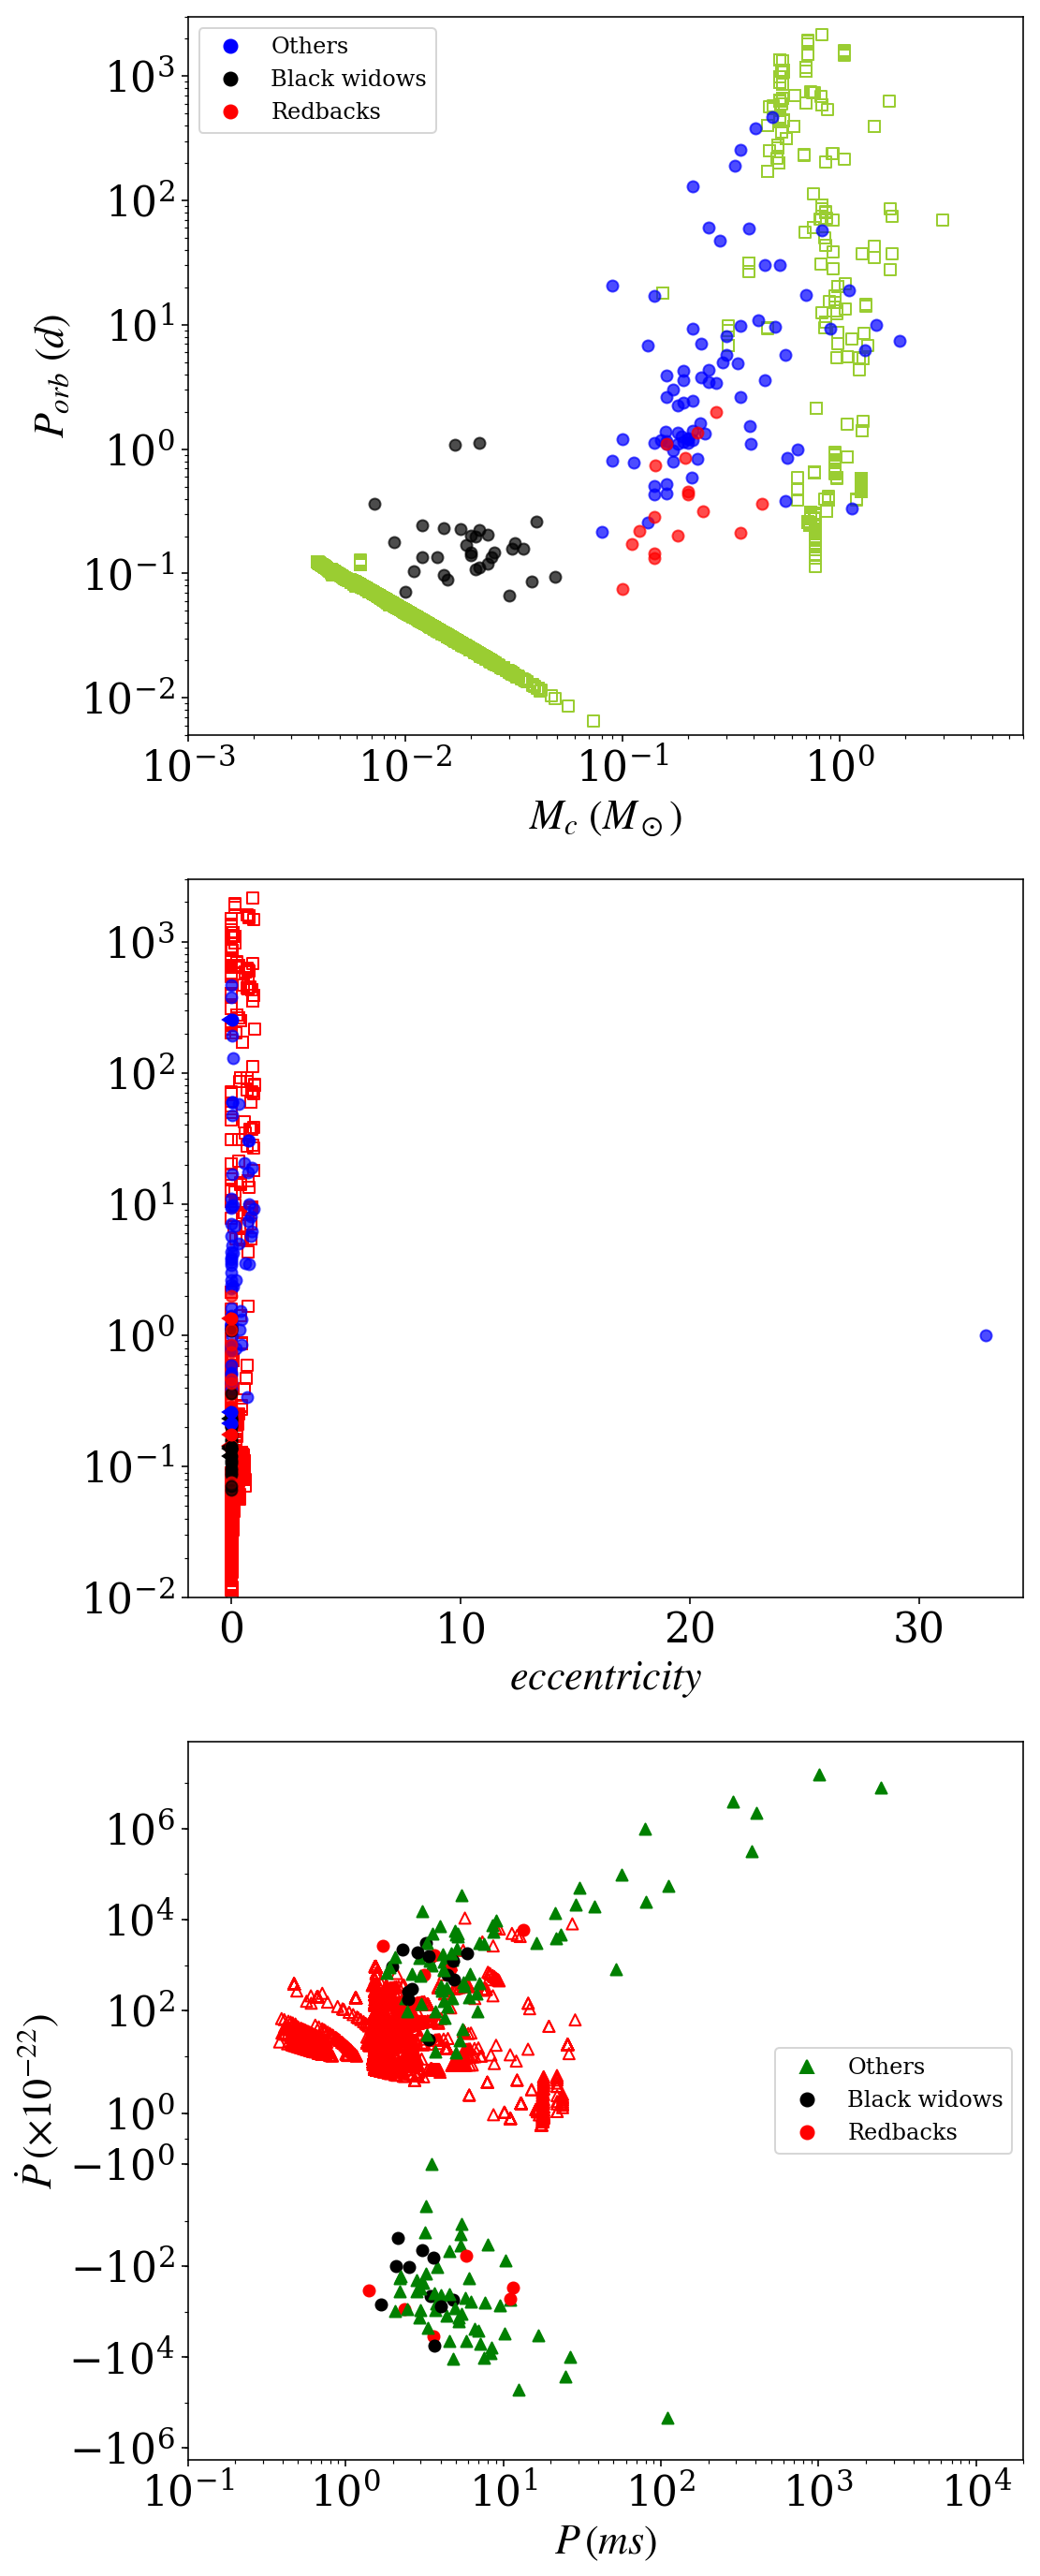

In [17]:
##Compare model pulsars Mc_Period with observed ones.

###Get model data
datamsp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/finaldata/msp_9to14Gyr.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/finaldata/normalpsr_maingrid_last.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


###Get observed data
P, Pdot, Binflag, Namespin, Period, Ecc, Mc, Names, Pall, Bfall, Nameall, Clusall = pc.readdata_freire(spinflag=1,offsetflag=0)

print(len(Pall), len(Bfall))
print(Ecc)
datarb=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCredback.dat', dtype=str)
databw=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/data_observed/GCblackwidow.dat', dtype=str)
namerb=datarb[:,0]; namebw=databw[:,0]


###Plotting
plt.rcParams['figure.figsize'] = [8,24]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')

fig, axs = plt.subplots(nrows=3, sharey=False)
fig.subplots_adjust(wspace=0.05)

#for jj in range(len(k0_psr)):
#    if k1_psr[jj]!=-100:
#        pb_psr = uc.au_to_period(sma_psr[jj], m0_psr[jj], m1_psr[jj])
#        if k1_psr[jj]<=1:
#            axs[0].scatter(m1_psr[jj], pb_psr, color='red', marker = 'd', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_psr[jj], pb_psr,  color='red', marker = 'd', lw = 1, facecolors='none')
#            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='red', lw = 1, facecolors='none')
#        elif k1_psr[jj]==10:
#            axs[0].scatter(m1_psr[jj], pb_psr, color='b', marker = 'd', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_psr[jj], pb_psr,  color='b', marker = 'd', lw = 1, facecolors='none')
#            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='g', lw = 1, facecolors='none')
#        elif k1_psr[jj]>=11 and m1_psr[jj]<0.1:
#            axs[0].scatter(m1_psr[jj], pb_psr, color='k', marker = 'd', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_psr[jj], pb_psr,  color='k', marker = 'd', lw = 1, facecolors='none')
#            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='k', lw = 1, facecolors='none')
#        elif k1_psr[jj]>=11 and m1_psr[jj]>=0.1:
#            axs[0].scatter(m1_psr[jj], pb_psr, color='b', marker = 'd', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_psr[jj], pb_psr,  color='b', marker = 'd', lw = 1, facecolors='none')
#            axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='g', lw = 1, facecolors='none')
#    else:
#        axs[2].scatter(P_psr[jj], Pdot_psr[jj], marker='>', color='g', lw = 1, facecolors='none')
        

#for kk in range(len(k0_msp)):
#    if k1_msp[kk]!=-100:
#        pb_msp = uc.au_to_period(sma_msp[kk], m0_msp[kk], m1_msp[kk])
#        if k1_msp[kk]<=1:
#            axs[0].scatter(m1_msp[kk], pb_msp, color='red', marker = 's', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_msp[kk], pb_msp,  color='red', marker = 's', lw = 1, facecolors='none')
#            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='red', lw = 1, facecolors='none')
#        elif k1_msp[kk]==10:
#            axs[0].scatter(m1_msp[kk], pb_msp, color='b', marker = 's', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_msp[kk], pb_msp,  color='b', marker = 's', lw = 1, facecolors='none')
#            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')
#        elif k1_msp[kk]>=11 and m1_msp[kk]<0.1:
#            axs[0].scatter(m1_msp[kk], pb_msp, color='k', marker = 's', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_msp[kk], pb_msp,  color='k', marker = 's', lw = 1, facecolors='none')
#            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='k', lw = 1, facecolors='none')
#        elif k1_msp[kk]>=11 and m1_msp[kk]>=0.1:
#            axs[0].scatter(m1_msp[kk], pb_msp, color='b', marker = 's', lw = 1, facecolors='none')
#            axs[1].scatter(ecc_msp[kk], pb_msp,  color='b', marker = 's', lw = 1, facecolors='none')
#            axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')
#    else:
#        axs[2].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')

pb_msp = uc.au_to_period(sma_msp[k1_msp!=-100], m0_msp[k1_msp!=-100], m1_msp[k1_msp!=-100])
axs[0].scatter(m1_msp[k1_msp!=-100], pb_msp, color='yellowgreen', marker = 's',  lw = 1, facecolors='none')
axs[1].scatter(ecc_msp[k1_msp!=-100], pb_msp,  color='red', marker = 's', lw = 1, facecolors='none')
axs[2].scatter(P_msp[k1_msp!=-100], Pdot_msp[k1_msp!=-100], marker='^', color='red', lw = 1, facecolors='none')
        
        

for i in range(len(Mc)):
    if Mc[i][0] != '>':
        if Names[i] in namerb:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='red', alpha=0.7, zorder=2)
            if Ecc[i][0]!='<' and Ecc[i][0]!='-':
                axs[1].scatter(float(Ecc[i]), float(Period[i]),  color='red', alpha=0.7, zorder=2)
            elif Ecc[i][0]!='-':
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='red', linestyle='none')
                
            
        elif Names[i] in namebw:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='k', alpha=0.7, zorder=2)
            else:
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='k', linestyle='none')
                
            
        else:
            axs[0].scatter(float(Mc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            if Ecc[i][0]!='<':
                axs[1].scatter(float(Ecc[i]), float(Period[i]), color='b', alpha=0.7, zorder=1)
            else:
                #print(Ecc[i])
                axs[1].errorbar(float(Ecc[i].split('<')[1]), float(Period[i]), xerr=0.02, 
                                xuplims=True,  marker='o', color='b', linestyle='none')
                
    
    else:
        axs[0].errorbar(float(Mc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.002, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        axs[1].errorbar(float(Ecc[i].split('>')[1]), float(Period[i].split('>')[1]), xerr=0.02, yerr=0.2, lolims=True, 
                        xlolims=True, marker='o', markerfacecolor='none', color='b', linestyle='none')
        

for j in range(len(P)):
    if Binflag[j]==0:
        axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='^', color='g')
    else:
        if Namespin[j] in namerb:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='o', color='r')
        elif Namespin[j] in namebw:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='o', color='k')
        else:
            axs[2].scatter(float(P[j]), float(Pdot[j])*10**22, marker='^', color='g')
            
            
        
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(0.005, 3000)
axs[0].set_xlim(0.001, 7)
axs[0].set_xlabel(r'$M_c\ (M_\odot)$')
axs[0].set_ylabel(r'$P_{orb}\ (d)$')
axs[0].legend(handles=[bdot, kdot, rdot], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

axs[1].set_yscale('log')
#axs[1].set_xscale('symlog')
axs[1].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[1].set_xlabel(r'$eccentricity$')
#axs[1].set_ylabel(r'$P_{orb}\ (d)$')

axs[2].set_xlim(0.1, 20000)
axs[2].set_yscale('symlog')
axs[2].set_xscale('log')
axs[2].legend(handles=[gtri, kdot, rdot], loc='center right', prop={'size': 12}, numpoints=1, frameon=True)
axs[2].set_xlabel(r'$P\,(ms)$')
axs[2].set_ylabel(r'$\dot{P}\,(\times 10^{-22})$')
axs[2].locator_params(numticks=8)
yticks =plt.gca().yaxis.get_major_ticks()
yticks[4].set_visible(False)

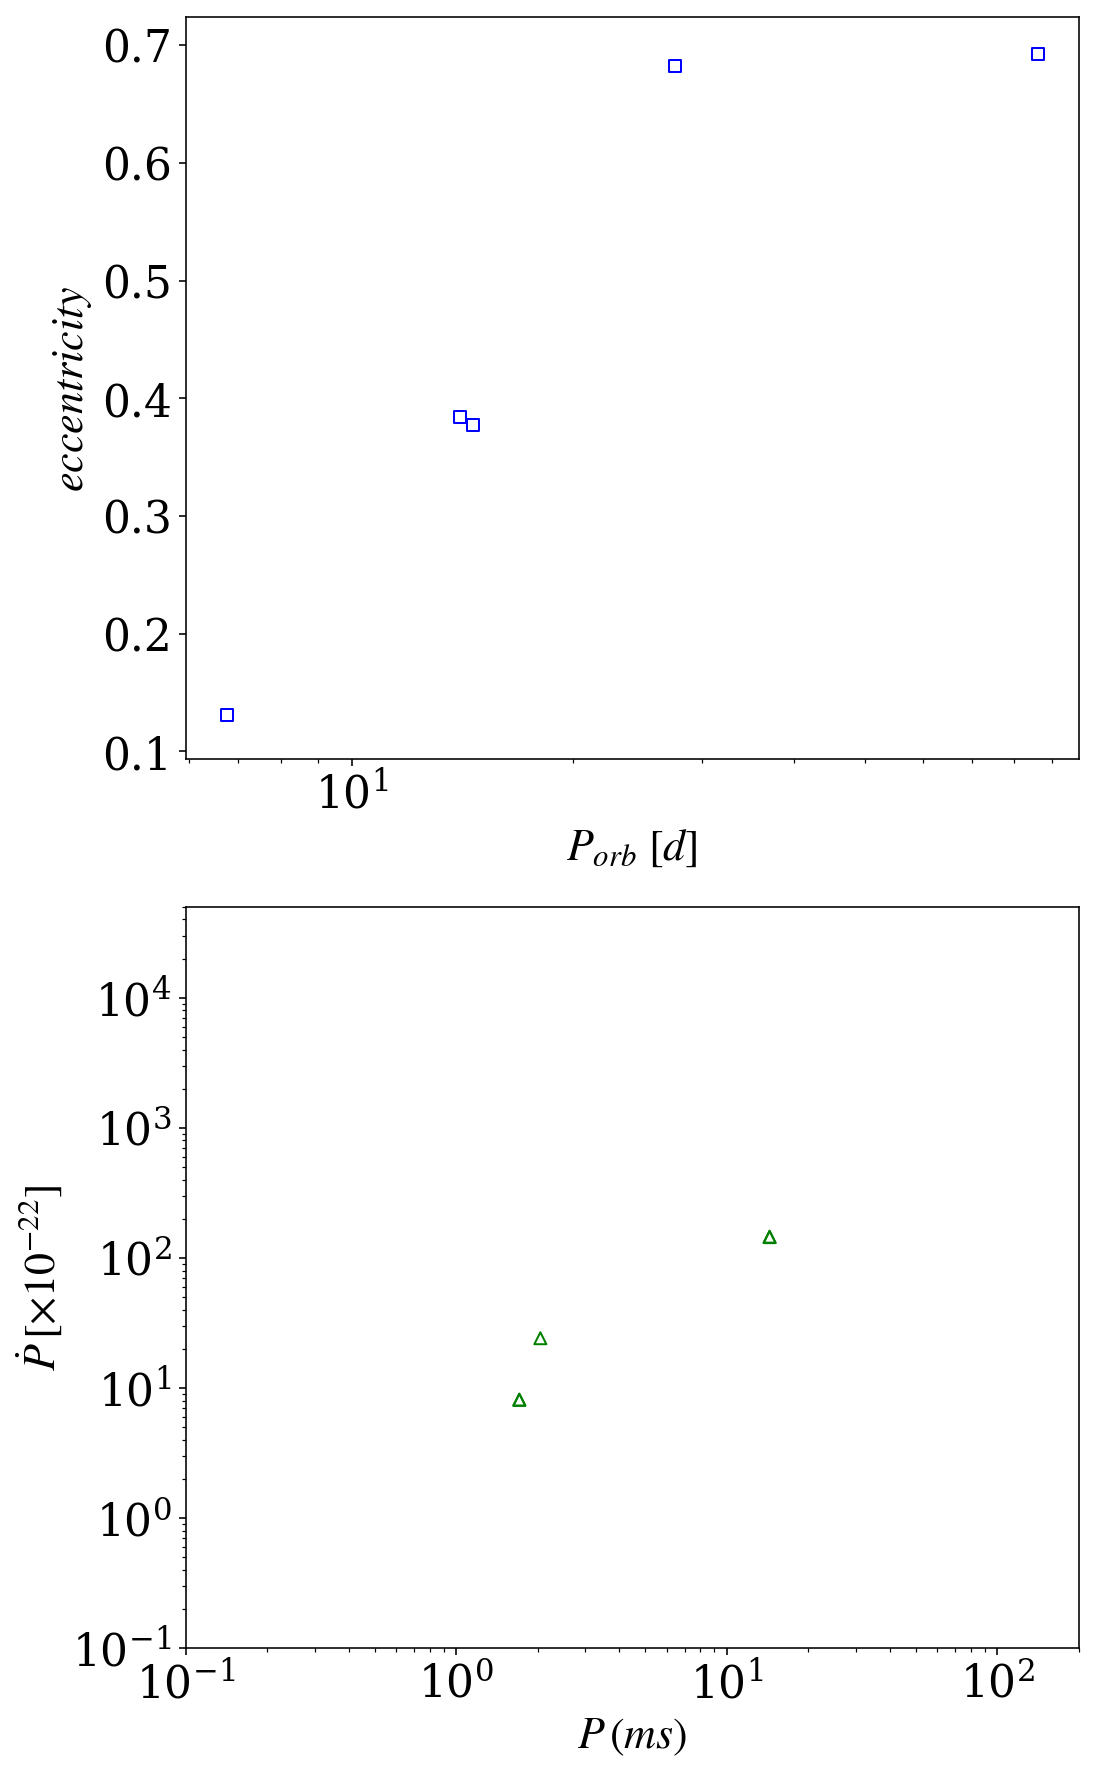

In [3]:
##Compare model pulsars Mc_Period, eccentricity, spin periods

###Get model data
datamsp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/finaldata/msp_9to14Gyr.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]

Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000
P_msp = P_msp*1000


###Plotting
plt.rcParams['figure.figsize'] = [8,15]
fig, axs = plt.subplots(nrows=2, sharey=False)
fig.subplots_adjust(wspace=0.05)

for kk in range(len(k0_msp)):
    if k1_msp[kk]!=-100:
        pb_msp = uc.au_to_period(sma_msp[kk], m0_msp[kk], m1_msp[kk])
        if k1_msp[kk] >=10 and m1_msp[kk]>=1.3:
            axs[0].scatter(pb_msp, ecc_msp[kk], color='b', marker = 's', lw = 1, facecolors='none')
            axs[1].scatter(P_msp[kk], Pdot_msp[kk], marker='^', color='g', lw = 1, facecolors='none')
                    
            
axs[0].set_xscale('log')
#axs[1].set_xscale('symlog')
#axs[0].set_ylim(0.01, 3000)
#axs[1].set_xlim(-0.1, 1)
axs[0].set_ylabel(r'$eccentricity$')
axs[0].set_xlabel(r'$P_{orb}\ [d]$')

axs[1].set_xlim(0.1, 200)
axs[1].set_ylim(ymin=0.1, ymax=5*10**4)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$P\,(ms)$')
axs[1].set_ylabel(r'$\dot{P}\,[\times 10^{-22}]$')
axs[1].locator_params(numticks=8)
yticks =plt.gca().yaxis.get_major_ticks()

2.297517 2.460133


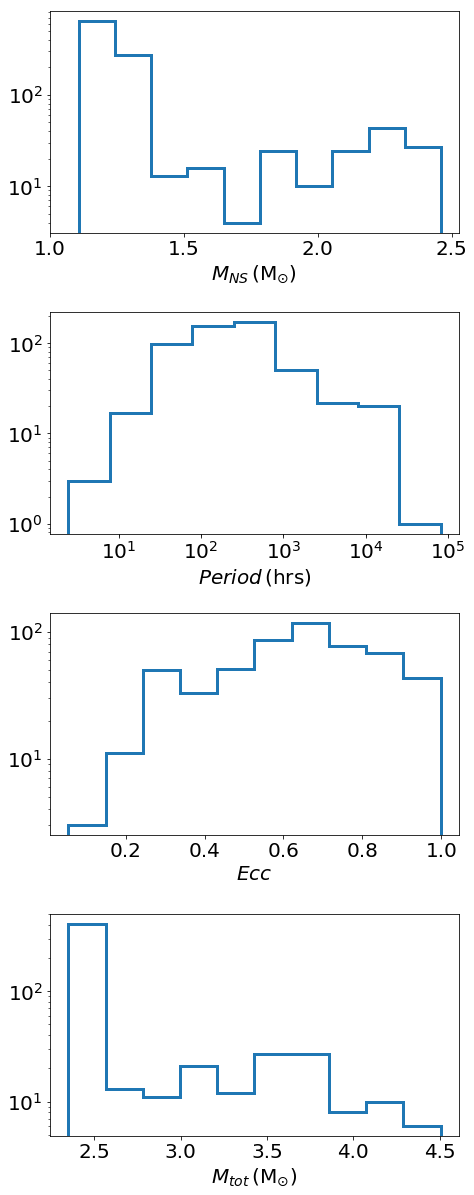

In [6]:
##Catalog model DNS mass and eccentricity distribution.

###Get model data
data_dns=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/NSNS_912gyr_maingrid_nondissolved.dat')
m0_dns=data_dns[:,5]; m1_dns=data_dns[:,6]; 
sma_dns = data_dns[:,15]; ecc_dns=data_dns[:,16]
period_days = uc.au_to_period(sma_dns, m0_dns, m1_dns)
period_hrs = period_days*24
print(np.max(m0_dns),np.max(m1_dns))
m_dns = list(m0_dns)+list(m1_dns)

matplotlib.rcParams.update({'font.size': 20})

## Plotting
fig, axs = plt.subplots(nrows=4, figsize = (7, 17))
axs[0].hist(m_dns, bins=10, histtype='step', lw=3)
axs[0].set_xlim(xmin=1.0)
axs[0].set_xlabel(r'$M_{NS}\,\rm(M_{\odot})$')
axs[0].set_yscale('log')

axs[1].hist(period_hrs,
           bins = np.logspace(np.log10(np.min(period_hrs)), np.log10(np.max(period_hrs)), 10),
           histtype = 'step', lw=3)
axs[1].set_xscale('symlog')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$Period\,\rm{(hrs)}$')

axs[2].hist(ecc_dns, bins = 10, histtype = 'step', lw = 3)
axs[2].set_xlabel(r'$Ecc$')
axs[2].set_yscale('log')
#yticks =plt.gca().yaxis.get_major_ticks()
#yticks[4].set_visible(False)

axs[3].hist(m0_dns+m1_dns, bins = 10, histtype = 'step', lw = 3)
axs[3].set_xlabel(r'$M_{tot}\,\rm{(M_{\odot})}$')
axs[3].set_yscale('log')
fig.tight_layout()

0.006087595009209722


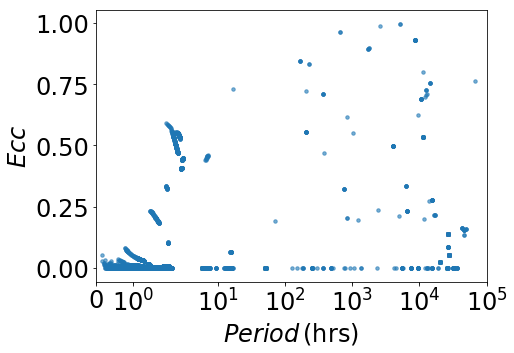

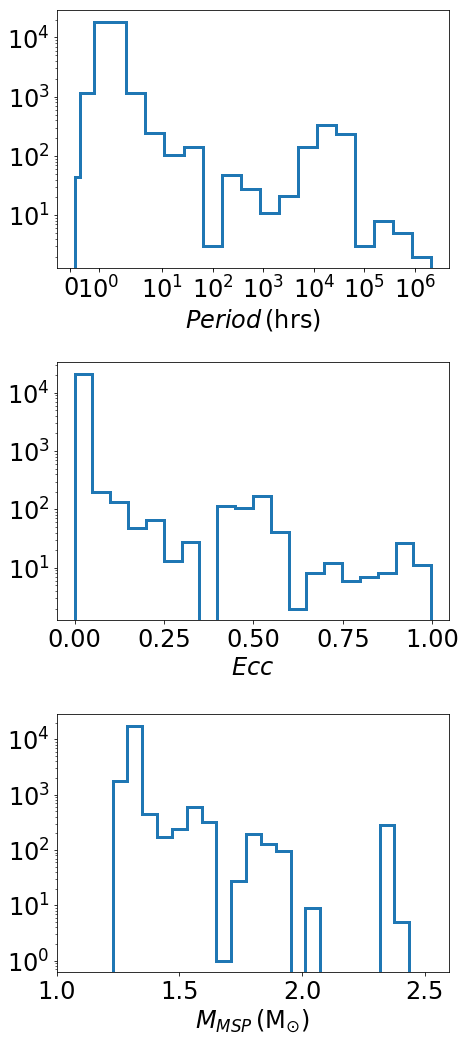

In [29]:
##Catalog model MSP mass and eccentricity distribution.
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

###Get model data
data_msp=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/MSP_912gyr_maingrid_nondissolved.dat')
m1=data_msp[:,6]
m0_msp=data_msp[:,5][m1!=-100]; m1_msp=m1[m1!=-100]
sma_msp = data_msp[:,15][m1!=-100]; ecc_msp=data_msp[:,16][m1!=-100]
period_days = uc.au_to_period(sma_msp, m0_msp, m1_msp)
period_hrs = period_days*24
print(np.min(period_days))


## Plotting
fig, axs = plt.subplots(figsize = (7,5))
axs.scatter(period_hrs, ecc_msp, alpha=0.6, s=12)
axs.set_xlim(xmin = 0, xmax=10**5)
axs.set_xscale('symlog')
axs.set_ylabel(r'$Ecc$')
axs.set_xlabel(r'$Period\,\rm{(hrs)}$')
#axs.set_yscale('log')

fig, axs = plt.subplots(nrows = 3, figsize = (7,15))
axs[0].hist(period_hrs,
           bins = np.logspace(np.log10(np.min(period_hrs)), np.log10(np.max(period_hrs)), 20),
           histtype = 'step', lw = 3)
axs[0].set_xscale('symlog')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$Period\,\rm{(hrs)}$')


axs[1].hist(ecc_msp, bins = 20, histtype = 'step', lw = 3)
axs[1].set_xlabel(r'$Ecc$')
axs[1].set_yscale('log')

axs[2].hist(m0_msp,
           bins = 20,#np.logspace(np.log10(np.min(m0_msp)), np.log10(np.max(m0_msp)), 25),
           histtype = 'step', lw = 3)
axs[2].set_xlabel(r'$M_{MSP}\,\rm{(M_{\odot})}$')
axs[2].set_xlim(xmin=1.0, xmax=2.6)
axs[2].set_yscale('log')
#axs[2].set_xscale('log')
axs[2].xaxis.set_major_locator(MultipleLocator(0.5))
axs[2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#yticks =plt.gca().yaxis.get_major_ticks()
#yticks[4].set_visible(False)
fig.tight_layout()


0.4675204047083038


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide


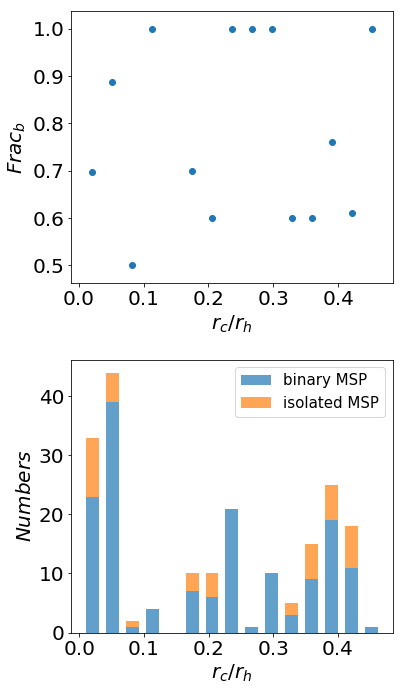

In [42]:
## isolated MSP fracion as a function of rc/rh
data_nmsp = np.genfromtxt('/projects/b1095/syr904/projects/PULSAR_Catalog/newruns/nmsp_rc_rh_12000myr.dat')
rc = data_nmsp[:,3]; rh = data_nmsp[:,4]
nmsp_sin = data_nmsp[:,5]; nmsp_bin = data_nmsp[:,6]
r_ratio = rc/rh
print(np.max(rc/rh))

r_ratio_bins = np.linspace(np.min(r_ratio), np.max(r_ratio), 16)
r_ratio_mean = []; nmsp_bin_tot = []; nmsp_sin_tot = []
for ii in range(len(r_ratio_bins)-1):
    r_ratio_mean.append((r_ratio_bins[ii+1]+r_ratio_bins[ii])/2.)
    nmsp_bin_tot.append(0); nmsp_sin_tot.append(0)
    for xx in range(len(r_ratio)):
        if r_ratio_bins[ii]<=r_ratio[xx]<=r_ratio_bins[ii+1]:
            nmsp_bin_tot[-1]+=nmsp_bin[xx]
            nmsp_sin_tot[-1]+=nmsp_sin[xx]

nmsp_bin_tot = np.array(nmsp_bin_tot)
nmsp_sin_tot = np.array(nmsp_sin_tot)
r_ratio_mean = np.array(r_ratio_mean)

matplotlib.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(nrows = 2, figsize = (6, 10))
axs[0].scatter(r_ratio_mean, 
               nmsp_bin_tot/(nmsp_bin_tot+nmsp_sin_tot))
axs[0].set_xlabel(r'$r_c/r_h$')
axs[0].set_ylabel(r'$Frac_b$')

axs[1].bar(r_ratio_mean, nmsp_bin_tot, width = 0.02, label = 'binary MSP',
          alpha = 0.7)
axs[1].bar(r_ratio_mean, nmsp_sin_tot, width = 0.02, bottom = nmsp_bin_tot, 
           label = 'isolated MSP', alpha=0.7)
axs[1].legend(loc='best', fontsize=15)
axs[1].set_xlabel(r'$r_c/r_h$')
axs[1].set_ylabel(r'$Numbers$')

fig.tight_layout()

In [4]:
##Check for potential bug in resetting the B-field and spin of MSPs
path = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/8e5/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.0002/8e5/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/8e5/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/1.6e6/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/1.6e6/',
        '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/']

for xx in range(len(path)):
    t_conv = dyn.conv('t', path[xx]+'initial.conv.sh')
    
    print(path[xx])
    ns_collproduct = np.genfromtxt(path[xx]+'ns_collproduct_all.dat')
    tcoll = ns_collproduct[:,1]
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    kall_nscol = [ns_collproduct[:,10].astype(np.int),ns_collproduct[:,11].astype(np.int),
                   ns_collproduct[:,12].astype(np.int),ns_collproduct[:,13].astype(np.int)]
    print('ntot NS coll', len(idm_nscol))
    #idm_nscol=idm_nscol[idm_nscol!=0]
    #print('ntot NS coll', len(idm_nscol))
    
    
    ns_merproduct = np.genfromtxt(path[xx]+'ns_mergerproduct_all.dat')
    tmer = ns_merproduct[:,1]
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    kall_nsmer = [ns_merproduct[:,8].astype(np.int),ns_merproduct[:,9].astype(np.int)]
    print('ntot NS mer', len(idm_nsmer))
    
    
    id_repeatcoll = []
    ncoll_0id = 0
    for ii in range(len(idm_nscol)):
        if idm_nscol[ii]==0:
            ncoll_0id+=1
            continue
        #for jj in range(len(idall_nscol)):
            #if idm_nscol[ii] in idall_nscol[jj]:
            #    id_repeatcoll.append([tcoll[idall_nscol[jj]==idm_nscol[ii]][0],
            #                         idm_nscol[idall_nscol[jj]==idm_nscol[ii]][0], idm_nscol[ii]])
            
        ###including all collisions here
        for jj in range(len(kall_nscol)):
            if kall_nscol[jj][ii]==13:
                id_repeatcoll.append([tcoll[ii], idm_nscol[ii], idall_nscol[jj][ii]])
    
    
    print('n repeating coll', len(id_repeatcoll)) 
    print('n coll 0 id', ncoll_0id)
    print(id_repeatcoll)           
                
    id_repeatmer = []
    nmer_0id = 0
    for ii in range(len(idm_nsmer)):
        if idm_nsmer[ii]==0:
            nmer_0id +=1
            continue
        #for jj in range(len(idall_nsmer)):
        #    if idm_nsmer[ii] in idall_nsmer[jj]:
        #        if jj==0 and tmer[idall_nsmer[jj]==idm_nsmer[ii]][0]!=tmer[ii]:
        #            id_repeatmer.append([tmer[idall_nsmer[jj]==idm_nsmer[ii]][0],
        #                                 idall_nsmer[jj+1][idall_nsmer[jj]==idm_nsmer[ii]][0], idm_nsmer[ii]])
        #        if jj==1 and tmer[idall_nsmer[jj]==idm_nsmer[ii]][0]!=tmer[ii]:
        #            id_repeatmer.append([tmer[idall_nsmer[jj]==idm_nsmer[ii]][0],
        #                                 idall_nsmer[jj-1][idall_nsmer[jj]==idm_nsmer[ii]][0], idm_nsmer[ii]])
        
        ###including all mergers here
        for jj in range(len(kall_nsmer)):
            if kall_nsmer[jj][ii]==13:
                id_repeatmer.append([tmer[ii], idm_nsmer[ii], idall_nsmer[jj][ii]])
    
    print('n repeating mer', len(id_repeatmer))
    print('n mer 0 id', nmer_0id)
    print(id_repeatmer)
    
    IDpsr = []; Ppsr = []
    IDmsp = []; Pmsp = [] 
    IDns = []
    psrfile = path[xx]+'initial.morepulsars.dat'
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            
            if int(data[2])!=1:
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDpsr.append(int(data[3]))
                    Ppsr.append(float(data[9]))
                else:
                    IDns.append(int(data[3]))
            else:
                if int(data[11])==13:
                    if float(data[7])>=float(data[9])**2*(0.17*10**12):
                        IDpsr.append(int(data[3]))
                        Ppsr.append(float(data[9]))
                    else:
                        IDns.append(int(data[3])) 

                if int(data[12])==13:
                    if float(data[8])>=float(data[10])**2*(0.17*10**12):
                        IDpsr.append(int(data[4]))
                        Ppsr.append(float(data[10]))
                    else:
                        IDns.append(int(data[3])) 
                    
    Ppsr = np.array(Ppsr)[np.array(IDpsr)!=0]
    IDpsr = np.array(IDpsr)[np.array(IDpsr)!=0]
    IDns = np.array(IDns)[np.array(IDns)!=0]
    IDmsp = IDpsr[Ppsr<=0.03]
    IDypsr = IDpsr[Ppsr>0.03]
    
    IDns_unique = Counter(IDns).keys()
    IDypsr_unique = Counter(IDypsr).keys()
    IDmsp_unique = Counter(IDmsp).keys()
    #print(len(IDns), len(IDns_unique))
    #print(len(IDypsr), len(IDypsr_unique))
    #print(len(IDmsp), len(IDmsp_unique))
    
    n_bug_coll = 0
    for kk in range(len(id_repeatcoll)):
        if id_repeatcoll[kk][1] in IDns_unique or id_repeatcoll[kk][1] in IDypsr_unique:
            if id_repeatcoll[kk][2] in IDmsp_unique:
                print(id_repeatcoll[kk])
                n_bug_coll+=1
            
    print('n_bug_coll', n_bug_coll)
    
    n_bug_mer = 0
    n_diffid = 0
    for kk in range(len(id_repeatmer)):
        if id_repeatmer[kk][1] != id_repeatmer[kk][2]:
            n_diffid +=1
            if id_repeatmer[kk][1] in IDns_unique or id_repeatmer[kk][1] in IDypsr_unique:
                if id_repeatmer[kk][2] in IDmsp_unique:
                    print(id_repeatmer[kk])
                    n_bug_mer+=1
        else:
            check_msp = [0,0]
            with open(psrfile, 'r') as fpsr:
                next(fpsr)
                for line in fpsr:
                    data = line.split()
                
                    if float(data[1])*t_conv >= id_repeatmer[kk][0]:
                        if int(data[2])!=1 and int(data[3]) == id_repeatmer[kk][1]:
                            #print(float(data[1])*t_conv, id_repeatmer[kk][0])
                            if float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9])<=0.03:
                                check_msp[1] = 1
                            
                            break
                            
                        else:
                            if int(data[11])==13 and int(data[3]) == id_repeatmer[kk][1]:
                                #print(float(data[1])*t_conv, id_repeatmer[kk][0])
                                if float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9])<=0.03:
                                    check_msp[1] = 1
                                
                                break
        
                            if int(data[12])==13 and int(data[4]) == id_repeatmer[kk][1]:
                                #print(float(data[1])*t_conv, id_repeatmer[kk][0])
                                if float(data[8])>=float(data[10])**2*(0.17*10**12) and float(data[10])<=0.03:
                                    check_msp[1] = 1
                            
                                break
                        
                    else:
                        if int(data[2])!=1 and int(data[3]) == id_repeatmer[kk][1]:
                            if float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9])<=0.03:
                                check_msp[0] = 1
                            else:
                                check_msp[0] = 0
                            BP = [float(data[7]), float(data[9])]
                            
                        else:
                            if int(data[11])==13 and int(data[3]) == id_repeatmer[kk][1]:
                                if float(data[7])>=float(data[9])**2*(0.17*10**12) and float(data[9])<=0.03:
                                    check_msp[0] = 1
                                else:
                                    check_msp[0] = 0
                                BP = [float(data[7]), float(data[9])]
        
                            if int(data[12])==13 and int(data[4]) == id_repeatmer[kk][1]:
                                if float(data[8])>=float(data[10])**2*(0.17*10**12) and float(data[10])<=0.03:
                                    check_msp[0] = 1
                                else:
                                    check_msp[0] = 0
                                BP = [float(data[8]), float(data[10])]
            
            print(BP)
    
            if check_msp[0]==1 and check_msp[1]==0:
                print(id_repeatmer[kk])
                n_bug_mer+=1
                    
                    
    print('n_bug_mer', n_bug_mer, n_diffid)

/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/
ntot NS coll 300
ntot NS mer 34
n repeating coll 183
n coll 0 id 1
[[1878.753034, 980594, 140594], [3953.73697, 1343711, 673957], [5347.273566, 1302132, 462132], [5530.39725, 947100, 794497], [5631.312726, 903310, 766544], [6334.924408, 1540344, 744138], [6645.899071, 1437787, 597787], [7137.672488, 1114460, 1437787], [7509.05492, 1147714, 307713], [7539.043159, 1052337, 227339], [7654.346251, 1046850, 507110], [7916.962353, 893948, 53948], [7953.622133, 1052139, 333687], [8078.561895, 1209659, 369659], [8092.713648, 980045, 1114460], [8224.39234, 1043351, 203351], [8226.414019, 881763, 536346], [8256.469647, 1029368, 197937], [8404.254382, 849469, 9469], [8495.634272, 918824, 78824], [8511.605536, 1082070, 612746], [8513.627216, 1106699, 266699], [8540.448157, 1281273, 801829], [8541.998111, 1087036, 247035], [8542.739393, 1036505, 1474026], [8558.171543, 1052141, 1052139], [8583.172973, 879137, 879135], [8592.337918, 93

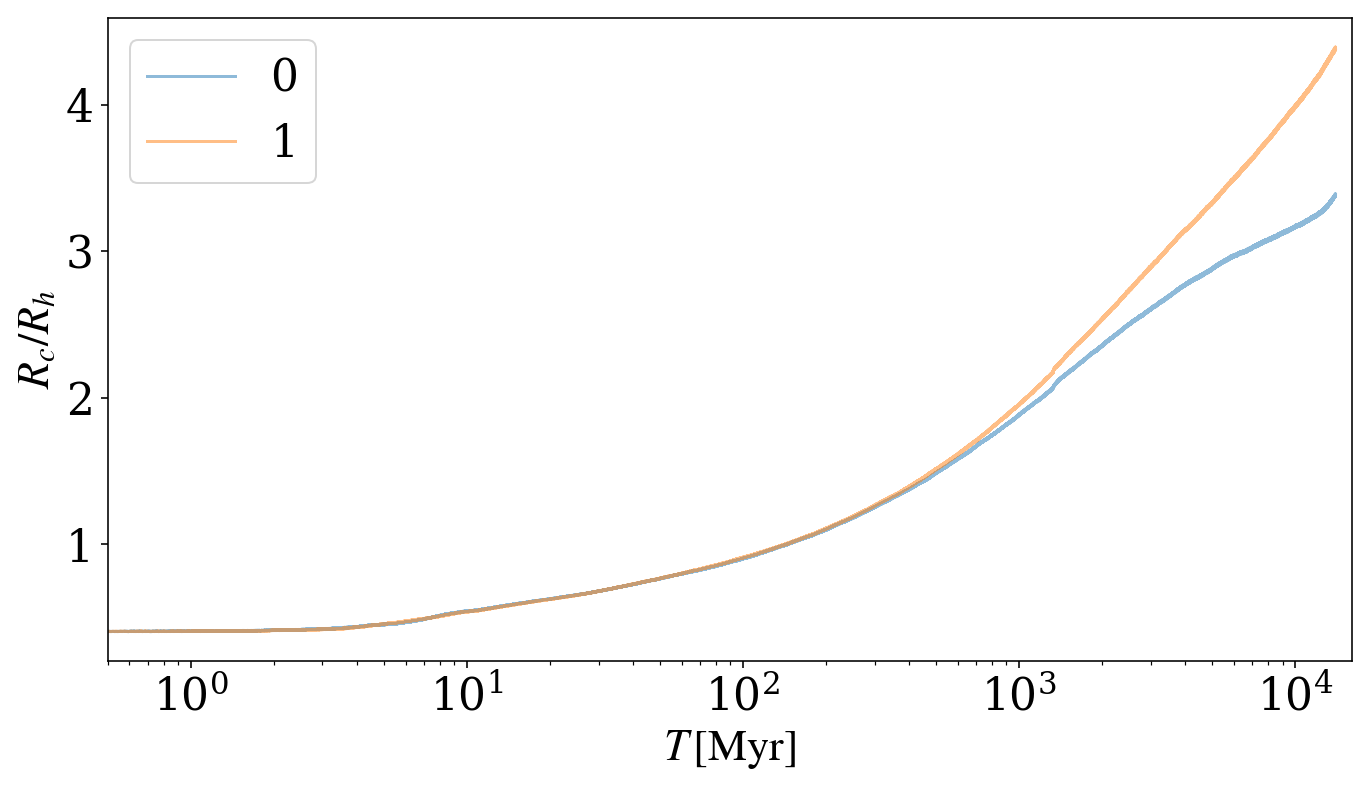

In [9]:
##Check the core-collapse time of clusters
paths = ['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg2/z0.002/1.6e6/',
        '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg20/z0.002/1.6e6/']

fig, axs = plt.subplots(figsize=(10, 6))
for xx in range(len(paths)): 
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    
    
    dynfile = np.genfromtxt(paths[xx]+'initial.dyn.dat')
    tdyn = dynfile[:,0]*t_conv; Rc = dynfile[:,7]*l_conv; Rh = dynfile[:,20]*l_conv
    Nc = dynfile[:,6]; rho_c = Nc/(2*twopi/3.)/Rc**3
    
    axs.plot(tdyn, Rh, alpha=0.5, label = str(xx))
    axs.set_xscale('log')
    axs.set_xlim(xmin=0.5, xmax=16000.)
    
    axs.set_ylabel(r'$R_c/R_h$')
    axs.set_xlabel(r'$T\,[\rm{Myr}]$') 
    
axs.legend(loc='best')
fig.tight_layout()
plt.subplots_adjust(hspace=0.04, wspace=0.16)